In [342]:
# Loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast 

np.random.seed(1)

In [343]:
# Function to load and filter dataframes
def load_filtered_dataframe(filepath):
    df = pd.read_csv(filepath)
    # if filter_score:
    #     df = df[df[column_to_filter] >= threshold]
    df['box'] = df['box'].apply(str_to_list)
    return df

# Function to calculate the Intersection over Union (IoU) of two boxes
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

# Function to convert string representation of list into an actual list
def str_to_list(box_str):
    return ast.literal_eval(box_str)


# # Function to compare benchmark and adversarial results and return the comparison results and statistics
# def get_comparisons(benchmark_df, adv_df, iterations_to_check):
#     comparison_results = []
#     stats = {
#         'correct detection': 0,
#         'correct detection with >0.2 score drop': 0,
#         'false negative': 0,
#         'false positive': 0,
#         'misclassification': 0,
#         'total adv detections': 0,
#         'total perturbation': 0
#     }

#     # Process the datasets
#     for image_idx in adv_df['image_index'].unique():
#         benchmark_subset = benchmark_df[benchmark_df['image_index'] == image_idx]
#         adv_rows = adv_df[adv_df['image_index'] == image_idx]

#         for iteration in iterations_to_check:
#             iteration_adv_rows = adv_rows[adv_rows['iteration'] == iteration]
#             stats['total adv detections'] += len(iteration_adv_rows)
#             stats['total perturbation'] += iteration_adv_rows['total_perturbation'].sum()  # Sum up the perturbation for each iteration

            
#             # Track the best score for each benchmark box matched with an adv box
#             best_score_adv_for_benchmark = {index: (None, -1) for index in benchmark_subset.index}
            
#             for _, adv_row in iteration_adv_rows.iterrows():
#                 adv_box = adv_row['box']
#                 best_iou = 0
#                 best_benchmark_index = None

#                 # Find the best match for this adv_box among all benchmark boxes
#                 for benchmark_index, benchmark_row in benchmark_subset.iterrows():
#                     benchmark_box = benchmark_row['box']
#                     iou = calculate_iou(adv_box, benchmark_box)
#                     if iou > best_iou:
#                         best_iou = iou
#                         best_benchmark_index = benchmark_index

#                 # If a match is found, check if this adv box has the highest score
#                 if best_iou >= 0.6:
#                     _, best_score = best_score_adv_for_benchmark[best_benchmark_index]
#                     if adv_row['score'] > best_score:
#                         best_score_adv_for_benchmark[best_benchmark_index] = (adv_row, adv_row['score'])

#             # Now, record the comparison results
#             for benchmark_index, (adv_row, _) in best_score_adv_for_benchmark.items():
#                 benchmark_row = benchmark_subset.loc[benchmark_index]
#                 benchmark_box = benchmark_row['box']
#                 if adv_row is not None:
#                     # Match found, determine if it's correct detection or misclassification
#                     adv_box = adv_row['box']
#                     iou = calculate_iou(adv_box, benchmark_box)
#                     if adv_row['class'] == benchmark_row['class']:
#                         stats['correct detection'] += 1
#                         result_type = 'correct detection'
#                         score_difference = adv_row['score'] - benchmark_row['score']
#                         if score_difference < -0.2:
#                             stats['correct detection with >0.2 score drop'] += 1
#                     else:
#                         stats['misclassification'] += 1
#                         result_type = 'misclassification'
#                     comparison_results.append({
#                         'image_index': image_idx,
#                         'iteration': iteration,
#                         'benchmark_class': benchmark_row['class'],
#                         'adv_class': adv_row['class'],
#                         'benchmark_score': benchmark_row['score'],
#                         'adv_score': adv_row['score'],
#                         'score_difference': score_difference,
#                         'iou': iou,
#                         'result_type': result_type
#                     })
#                 else:
#                     # No match found, record as false negative
#                     stats['false negative'] += 1
#                     comparison_results.append({
#                         'image_index': image_idx,
#                         'iteration': iteration,
#                         'benchmark_class': benchmark_row['class'],
#                         'adv_class': 'no_detection',
#                         'benchmark_score': benchmark_row['score'],
#                         'adv_score': None,
#                         'score_difference': None,
#                         'iou': 0,
#                         'result_type': 'false negative'
#                     })

#             # Check for any adv detections that weren't the best match and record as false positive
#             for _, adv_row in iteration_adv_rows.iterrows():
#                 adv_box = adv_row['box']
#                 is_false_positive = True
#                 for benchmark_index, (best_match_adv_row, _) in best_score_adv_for_benchmark.items():
#                     if best_match_adv_row is not None and best_match_adv_row.equals(adv_row):
#                         is_false_positive = False
#                         break
#                 if is_false_positive:
#                     stats['false positive'] += 1
#                     comparison_results.append({
#                         'image_index': image_idx,
#                         'iteration': iteration,
#                         'benchmark_class': None,
#                         'adv_class': adv_row['class'],
#                         'benchmark_score': None,
#                         'adv_score': adv_row['score'],
#                         'score_difference': None,
#                         'iou': 0,
#                         'result_type': 'false positive'
#                     })

#     # Calculate total possible detections: number of benchmark boxes * number of iterations
#     stats['total adv detections'] += stats['false negative']
#     # Correct Detection Rate

#     stats['correct detection rate'] = stats['correct detection'] / stats['total adv detections']
#     stats['false negative rate'] = stats['false negative'] / stats['total adv detections']
#     stats['false positive rate'] = stats['false positive'] / stats['total adv detections']
#     stats['misclassification rate'] = stats['misclassification'] / stats['total adv detections']
#     stats['average perturbation'] = stats['total perturbation'] / stats['total adv detections']
#     stats['classification failure rate'] = 1 - stats['correct detection rate']
    
#     return comparison_results, stats

# Function to compare benchmark and adversarial results and return the comparison results and statistics
def get_comparisons(benchmark_df, adv_df, iterations_to_check):
    comparison_results = []
    stats = {
        'correct detection': 0,
        'correct detection with >0.2 score drop': 0,
        'false negative': 0,
        'false positive': 0,
        'misclassification': 0,
        'total adv detections': 0,
        'total perturbation': 0
    }

    # Process the datasets
    for image_idx in adv_df['image_index'].unique():
        benchmark_subset = benchmark_df[benchmark_df['image_index'] == image_idx]
        adv_rows = adv_df[adv_df['image_index'] == image_idx]

        for iteration in iterations_to_check:
            iteration_adv_rows = adv_rows[adv_rows['iteration'] == iteration]
            stats['total adv detections'] += len(iteration_adv_rows)
            stats['total perturbation'] += iteration_adv_rows['total_perturbation'].sum()  # Sum up the perturbation for each iteration

            
            # Track the best score for each benchmark box matched with an adv box
            best_score_adv_for_benchmark = {index: (None, -1) for index in benchmark_subset.index}
            
            for _, adv_row in iteration_adv_rows.iterrows():
                adv_box = adv_row['box']
                best_iou = 0
                best_benchmark_index = None

                # Find the best match for this adv_box among all benchmark boxes
                for benchmark_index, benchmark_row in benchmark_subset.iterrows():
                    benchmark_box = benchmark_row['box']
                    iou = calculate_iou(adv_box, benchmark_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_benchmark_index = benchmark_index

                # If a match is found, check if this adv box has the highest score
                if best_iou >= 0.6:
                    _, best_score = best_score_adv_for_benchmark[best_benchmark_index]
                    if adv_row['score'] > best_score:
                        best_score_adv_for_benchmark[best_benchmark_index] = (adv_row, adv_row['score'])

            # Now, record the comparison results
            for benchmark_index, (adv_row, _) in best_score_adv_for_benchmark.items():
                benchmark_row = benchmark_subset.loc[benchmark_index]
                benchmark_box = benchmark_row['box']
                if adv_row is not None:
                    # Match found, determine if it's correct detection or misclassification
                    adv_box = adv_row['box']
                    iou = calculate_iou(adv_box, benchmark_box)
                    if adv_row['class'] == benchmark_row['class']:
                        stats['correct detection'] += 1
                        result_type = 'correct detection'
                        # score_difference = adv_row['score'] - benchmark_row['score']
                        # if score_difference < -0.2:
                        #     stats['correct detection with >0.2 score drop'] += 1
                    else:
                        stats['misclassification'] += 1
                        result_type = 'misclassification'
                    comparison_results.append({
                        'image_index': image_idx,
                        'iteration': iteration,
                        'benchmark_class': benchmark_row['class'],
                        'adv_class': adv_row['class'],
                        'benchmark_score': benchmark_row['score'],
                        'adv_score': adv_row['score'],
                        # 'score_difference': score_difference,
                        'iou': iou,
                        'result_type': result_type
                    })
                else:
                    # No match found, record as false negative
                    stats['false negative'] += 1
                    comparison_results.append({
                        'image_index': image_idx,
                        'iteration': iteration,
                        'benchmark_class': benchmark_row['class'],
                        'adv_class': 'no_detection',
                        'benchmark_score': benchmark_row['score'],
                        'adv_score': None,
                        'score_difference': None,
                        'iou': 0,
                        'result_type': 'false negative'
                    })

            # Check for any adv detections that weren't the best match and record as false positive
            for _, adv_row in iteration_adv_rows.iterrows():
                adv_box = adv_row['box']
                is_false_positive = True
                for benchmark_index, (best_match_adv_row, _) in best_score_adv_for_benchmark.items():
                    if best_match_adv_row is not None and best_match_adv_row.equals(adv_row):
                        is_false_positive = False
                        break
                if is_false_positive:
                    stats['false positive'] += 1
                    comparison_results.append({
                        'image_index': image_idx,
                        'iteration': iteration,
                        'benchmark_class': None,
                        'adv_class': adv_row['class'],
                        'benchmark_score': None,
                        'adv_score': adv_row['score'],
                        'score_difference': None,
                        'iou': 0,
                        'result_type': 'false positive'
                    })

    # Calculate total possible detections: number of benchmark boxes * number of iterations
    stats['total adv detections'] += stats['false negative']
    # Correct Detection Rate

    stats['correct detection rate'] = stats['correct detection'] / stats['total adv detections']
    stats['false negative rate'] = stats['false negative'] / stats['total adv detections']
    stats['false positive rate'] = stats['false positive'] / stats['total adv detections']
    stats['misclassification rate'] = stats['misclassification'] / stats['total adv detections']
    stats['average perturbation'] = stats['total perturbation'] / stats['total adv detections']
    stats['classification failure rate'] = 1 - stats['correct detection rate']
    
    return comparison_results, stats

# Function to print the detection statistics
def print_stats(stats):
    print("Detection Statistics:\n")
    for key, value in stats.items():
        if "rate" in key:
            print(f"{key.ljust(40)}: {value:.2%}")
        else:
            print(f"{key.ljust(40)}: {value}")

# Function to save the comparison results to a CSV file
def save_results(comparison_results, filepath):
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df.to_csv(filepath, index=False)


In [344]:
iterations_to_check = [1,2,3,4,5,6]

# Different Perturbation Norms

In [345]:
iterations_to_check = [1,2,3,4,5,6]

In [346]:
# benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv"
# adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/200_images_9/adv_alg9_results.csv"


benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_101_0/faster_rcnn_alg0_results.csv"
adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn__resnet_random_0/adv_alg0_results.csv"

# Load and filter dataframes
benchmark_df = load_filtered_dataframe(benchmark_filepath)
adv_df = load_filtered_dataframe(adv_filepath)
adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

# Get comparisons and stats
comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

# Print stats and save results
print_stats(stats)
save_results(comparison_results, '/Users/yuxing/traffic-sign-detection/200img/comparison_results1.csv')

# Perturbation vs Classification failure rate

In [347]:
# Load and filter dataframes for multiple datasets
filepaths = ["/Users/yuxing/traffic-sign-detection/200img/200_images_1/adv_alg1_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_2/adv_alg2_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_3/adv_alg3_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_4/adv_alg4_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_5/adv_alg5_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_6/adv_alg6_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_7/adv_alg7_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_8/adv_alg8_results.csv", 
             "/Users/yuxing/traffic-sign-detection/200img/200_images_9/adv_alg9_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_10/adv_alg2_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_11/adv_alg3_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_12/adv_alg12_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_13/adv_alg13_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_14/adv_alg14_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_15/adv_alg15_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_16/adv_alg16_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_17/adv_alg17_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_18/adv_alg18_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_19/adv_alg19_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_20/adv_alg20_results.csv"]

all_adv_dfs = [load_filtered_dataframe(fp) for fp in filepaths]

# Placeholder for your iterations to check
iterations_to_check = [1, 2, 3, 4, 5, 6] 

# Initialize lists to hold comparison stats
average_perturbations = []
classification_failure_rates = []

# Iterate over the adversarial datasets
for adv_df in all_adv_dfs:
    # Placeholder for your benchmark dataframe
    benchmark_df = load_filtered_dataframe("/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv")
    
    # Apply additional filtering
    adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
    adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

    # Get comparisons and stats
    comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

    # Collect the stats needed for plotting
    average_perturbations.append(stats['average perturbation'])
    classification_failure_rates.append(stats['classification failure rate'])

    print_stats(stats)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.scatter(average_perturbations, classification_failure_rates, color='blue')
plt.title('Perturbation vs Classification Failure Rate')
plt.xlabel('Average Perturbation')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.show()


In [348]:
# Load and filter dataframes for multiple datasets
filepaths = ["/Users/yuxing/traffic-sign-detection/200img/200_images_1/adv_alg1_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_12/adv_alg12_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_15/adv_alg15_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_18/adv_alg18_results.csv"]

all_adv_dfs = [load_filtered_dataframe(fp) for fp in filepaths]

# Placeholder for your iterations to check
iterations_to_check = [1, 2, 3, 4, 5, 6]  # Define your iterations

# Initialize lists to hold comparison stats
average_perturbations = []
classification_failure_rates = []

# Iterate over the adversarial datasets, process them, and collect stats
for adv_df in all_adv_dfs:
    # Placeholder for your benchmark dataframe
    benchmark_df = load_filtered_dataframe("/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv")
    
    # Apply additional filtering if needed, as per your example
    adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
    adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

    # Get comparisons and stats
    comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

    # Collect the stats needed for plotting
    average_perturbations.append(stats['average perturbation'])
    classification_failure_rates.append(stats['classification failure rate'])

    print_stats(stats)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.scatter(average_perturbations, classification_failure_rates, color='blue')
plt.title('Perturbation vs Classification Failure Rate')
plt.xlabel('Average Perturbation')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.show()


In [349]:
# Load and filter dataframes for multiple datasets
filepaths = ["/Users/yuxing/traffic-sign-detection/200img/200_images_2/adv_alg2_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_4/adv_alg4_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_6/adv_alg6_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_8/adv_alg8_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_10/adv_alg2_results.csv"]

all_adv_dfs = [load_filtered_dataframe(fp) for fp in filepaths]

# Placeholder for your iterations to check
iterations_to_check = [1, 2, 3, 4, 5, 6]  # Define your iterations

# Initialize lists to hold comparison stats
average_perturbations = []
classification_failure_rates = []

# Iterate over the adversarial datasets, process them, and collect stats
for adv_df in all_adv_dfs:
    # Placeholder for your benchmark dataframe
    benchmark_df = load_filtered_dataframe("/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv")
    
    # Apply additional filtering if needed, as per your example
    adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
    adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

    # Get comparisons and stats
    comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

    # Collect the stats needed for plotting
    average_perturbations.append(stats['average perturbation'])
    classification_failure_rates.append(stats['classification failure rate'])

    print_stats(stats)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.scatter(average_perturbations, classification_failure_rates, color='blue')
plt.title('Perturbation vs Classification Failure Rate')
plt.xlabel('Average Perturbation')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.show()


In [350]:
# Load and filter dataframes for multiple datasets
filepaths = ["/Users/yuxing/traffic-sign-detection/200img/200_images_3/adv_alg3_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_5/adv_alg5_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_7/adv_alg7_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_9/adv_alg9_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_11/adv_alg3_results.csv"]

all_adv_dfs = [load_filtered_dataframe(fp) for fp in filepaths]

# Placeholder for your iterations to check
iterations_to_check = [1, 2, 3, 4, 5, 6]  # Define your iterations

# Initialize lists to hold comparison stats
average_perturbations = []
classification_failure_rates = []

# Iterate over the adversarial datasets, process them, and collect stats
for adv_df in all_adv_dfs:
    # Placeholder for your benchmark dataframe
    benchmark_df = load_filtered_dataframe("/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv")
    
    # Apply additional filtering if needed, as per your example
    adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
    adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

    # Get comparisons and stats
    comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

    # Collect the stats needed for plotting
    average_perturbations.append(stats['average perturbation'])
    classification_failure_rates.append(stats['classification failure rate'])

    print_stats(stats)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.scatter(average_perturbations, classification_failure_rates, color='blue')
plt.title('Perturbation vs Classification Failure Rate')
plt.xlabel('Average Perturbation')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.show()


# Check different iterations

In [351]:
iterations_to_check = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# A function to print stats for each iteration
def print_iteration_stats(iteration, iter_stats):
    print(f"Iteration {iteration} Statistics:")
    for key, value in iter_stats.items():
        print(f"  {key}: {value}")
    print()

# # Print stats for each iteration
# for iteration, stats in iteration_stats.items():
#     print_iteration_stats(iteration, stats)

# Generalization on different models

In [358]:
benchmark_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_101_0/faster_rcnn_alg0_results.csv"
# adv_filepath = "/Users/yuxing/traffic-sign-detection/modified_adv_df_sample.csv"
adv_filepath = "/Users/yuxing/traffic-sign-detection/200img/faster_rcnn_resnet_101_1/faster_rcnn_alg1_results.csv"

# Load and filter dataframes
benchmark_df = load_filtered_dataframe(benchmark_filepath)
adv_df = load_filtered_dataframe(adv_filepath)
adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

# Get comparisons and stats
comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

# Print stats and save results
print_stats(stats)
save_results(comparison_results, '/Users/yuxing/traffic-sign-detection/200img/comparison_results1.csv')

Detection Statistics:

correct detection                       : 1967
correct detection with >0.2 score drop  : 0
false negative                          : 293
false positive                          : 147
misclassification                       : 210
total adv detections                    : 2617
total perturbation                      : 0
correct detection rate                  : 75.16%
false negative rate                     : 11.20%
false positive rate                     : 5.62%
misclassification rate                  : 8.02%
average perturbation                    : 0.0
classification failure rate             : 24.84%


# Check different EPS

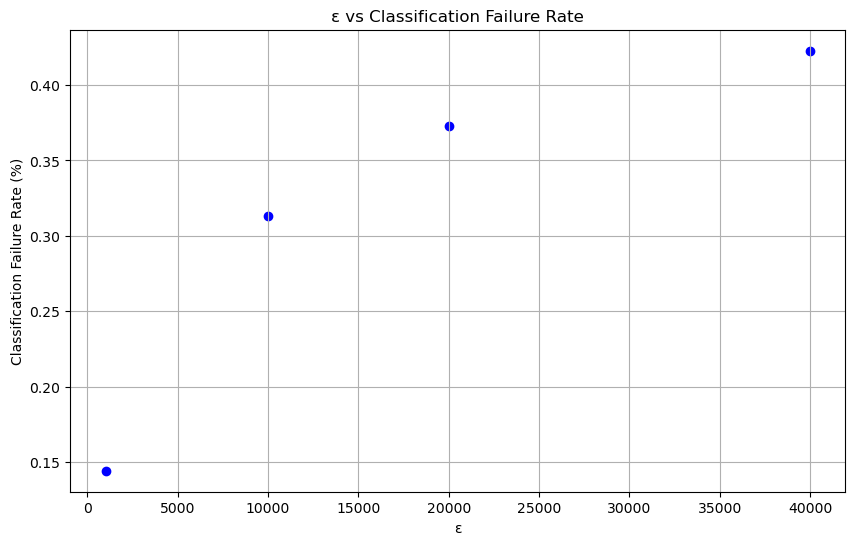

In [359]:
filepaths = ["/Users/yuxing/traffic-sign-detection/200img/200_images_1/adv_alg1_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_12/adv_alg12_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_15/adv_alg15_results.csv",
             "/Users/yuxing/traffic-sign-detection/200img/200_images_18/adv_alg18_results.csv"]

all_adv_dfs = [load_filtered_dataframe(fp) for fp in filepaths]

iterations_to_check = [1, 2, 3, 4, 5, 6]

# Initialize lists to hold comparison stats
average_perturbations = []
classification_failure_rates = []

# Iterate over the adversarial datasets
for adv_df in all_adv_dfs:
    # Placeholder for your benchmark dataframe
    benchmark_df = load_filtered_dataframe("/Users/yuxing/traffic-sign-detection/200img/test_image_results/200_images_0/adv_alg0_results.csv")
    
    # Apply additional filtering
    adv_df.loc[adv_df['score'] < 0.5, 'class'] = 'no_detection'
    adv_df = adv_df[adv_df['iteration'].isin(iterations_to_check)]

    # Get comparisons and stats
    comparison_results, stats = get_comparisons(benchmark_df, adv_df, iterations_to_check)

    # Collect the stats needed for plotting
    # average_perturbations.append(stats['average perturbation'])
    EPS = [40000,20000,10000,1000]
    classification_failure_rates.append(stats['classification failure rate'])

    # print_stats(stats)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.scatter(EPS, classification_failure_rates, color='blue')


plt.title('ε vs Classification Failure Rate')
plt.xlabel('ε')
plt.ylabel('Classification Failure Rate (%)')
plt.grid(True)
plt.show()


# Load and compare the patched images

In [360]:
# import pickle
# import numpy as np
# import pandas as pd
# import os

# # Load data from a pickle file
# with open('results.pkl', 'rb') as file:
#     result = pickle.load(file)

# # Now iterate over each item and filter out detections with scores > 0.5
# filtered_result = {}

# for image_path, detection_data in result.items():
#     if 'scores' in detection_data:
#         # Assume the 'scores' are in the second dimension as seen in previous snippets
#         high_score_indices = np.where(detection_data['scores'] > 0.5)[1]

#         filtered_boxes = detection_data['boxes'][:, high_score_indices, :]
#         filtered_scores = detection_data['scores'][:, high_score_indices]

#         # Insert filtered data back into the result structure
#         filtered_result[image_path] = {
#             'boxes': filtered_boxes,
#             'scores': filtered_scores,
#             # Include 'classes' if they are also present
#             'classes': detection_data['classes'][:, high_score_indices] if 'classes' in detection_data else None
#         }

# # Assuming 'classes_mapping' is a dictionary that maps class ids to class names
# classes_mapping = {
#     1: "Class 1 Name",
#     2: "Class 2 Name",
#     3: "Class 3 Name",
#     # Add more mappings as necessary
# }

# # Initialize a list to hold all the rows for the DataFrame
# df_data = []

# # Iterate over each image and its detections
# for image_path, detection_data in filtered_result.items():
#     image_name = os.path.basename(image_path)
#     image_index = int(image_name.split('_')[2].split('.')[0])
    
#     # Each detection data ('boxes', 'scores', 'classes') is a numpy array within an array, even if there's only one detection.
#     # Flatten the arrays for consistent processing.
#     boxes = detection_data['boxes'].reshape(-1, 4)
#     scores = detection_data['scores'].flatten()
#     classes = detection_data['classes'].flatten()
    
#     for score, box, class_id in zip(scores, boxes, classes):
#         # Convert the class_id to int and get the class name
#         class_id = int(class_id)
#         class_name = classes_mapping.get(class_id, "unknown")

#         # Create a dictionary for the row
#         row = {
#             'image_index': image_index,
#             'image_name': image_name,
#             'iteration': 0,
#             'class': class_name,
#             'score': score,
#             'box': box.tolist(),
#             'total_perturbation': 0,
#             'adv_success': 0
#         }
        
#         # Add the row to the list
#         df_data.append(row)

# # Convert the list of rows to a DataFrame
# df = pd.DataFrame(df_data)

# # Filter the DataFrame for rows where the 'image_name' column contains 'test_image'
# test_images_df = df[df['image_name'].str.contains('test_image')]

# # Filter the DataFrame for rows where the 'image_name' column contains 'patch_image'
# patch_images_df = df[df['image_name'].str.contains('patch_image')]

# # Save the filtered DataFrames as CSV files
# test_images_df.to_csv('test_images.csv', index=False)
# patch_images_df.to_csv('patch_images.csv', index=False)


In [361]:
# test_images_df = pd.read_csv('/Users/yuxing/traffic-sign-detection/test_images.csv')
# patch_images_df = pd.read_csv('/Users/yuxing/traffic-sign-detection/patch_images.csv')
# test_images_df['box'] = test_images_df['box'].apply(str_to_list)
# patch_images_df['box'] = patch_images_df['box'].apply(str_to_list)
# iterations_to_check = [0]
# # Get comparisons and stats
# comparison_results, stats = get_comparisons(test_images_df, patch_images_df, iterations_to_check)

# # Print stats and save results
# print_stats(stats)
# save_results(comparison_results, '/Users/yuxing/traffic-sign-detection/200img/patch_results.csv')

# Compare results

In [362]:
# # Function to compare benchmark and adversarial results and return the comparison results and statistics
# def get_comparisons(benchmark_df, adv_df, iterations_to_check):
#     comparison_results = []
#     stats = {
#         'correct detection': 0,
#         'correct detection with >0.2 score drop': 0,
#         'false negative': 0,
#         'false positive': 0,
#         'misclassification': 0,
#         'total adv detections': 0,
#         'total perturbation': 0
#     }

#     # Process the datasets
#     for image_idx in adv_df['image_index'].unique():
#         benchmark_subset = benchmark_df[benchmark_df['image_index'] == image_idx]
#         adv_rows = adv_df[adv_df['image_index'] == image_idx]

#         for iteration in iterations_to_check:
#             iteration_adv_rows = adv_rows[adv_rows['iteration'] == iteration]
#             stats['total adv detections'] += len(iteration_adv_rows)
#             stats['total perturbation'] += iteration_adv_rows['total_perturbation'].sum()  # Sum up the perturbation for each iteration

            
#             # Track the best score for each benchmark box matched with an adv box
#             best_score_adv_for_benchmark = {index: (None, -1) for index in benchmark_subset.index}
            
#             for _, adv_row in iteration_adv_rows.iterrows():
#                 adv_box = adv_row['box']
#                 best_iou = 0
#                 best_benchmark_index = None

#                 # Find the best match for this adv_box among all benchmark boxes
#                 for benchmark_index, benchmark_row in benchmark_subset.iterrows():
#                     benchmark_box = benchmark_row['box']
#                     iou = calculate_iou(adv_box, benchmark_box)
#                     if iou > best_iou:
#                         best_iou = iou
#                         best_benchmark_index = benchmark_index

#                 # If a match is found, check if this adv box has the highest score
#                 if best_iou >= 0.6:
#                     _, best_score = best_score_adv_for_benchmark[best_benchmark_index]
#                     if adv_row['score'] > best_score:
#                         best_score_adv_for_benchmark[best_benchmark_index] = (adv_row, adv_row['score'])

#             # Now, record the comparison results
#             for benchmark_index, (adv_row, _) in best_score_adv_for_benchmark.items():
#                 benchmark_row = benchmark_subset.loc[benchmark_index]
#                 benchmark_box = benchmark_row['box']
#                 if adv_row is not None:
#                     # Match found, determine if it's correct detection or misclassification
#                     adv_box = adv_row['box']
#                     iou = calculate_iou(adv_box, benchmark_box)
#                     if adv_row['class'] == benchmark_row['class']:
#                         stats['correct detection'] += 1
#                         result_type = 'correct detection'
#                         score_difference = adv_row['score'] - benchmark_row['score']
#                         if score_difference < -0.2:
#                             stats['correct detection with >0.2 score drop'] += 1
#                     else:
#                         stats['misclassification'] += 1
#                         result_type = 'misclassification'
#                     comparison_results.append({
#                         'image_index': image_idx,
#                         'iteration': iteration,
#                         'benchmark_class': benchmark_row['class'],
#                         'adv_class': adv_row['class'],
#                         'benchmark_score': benchmark_row['score'],
#                         'adv_score': adv_row['score'],
#                         'score_difference': score_difference,
#                         'iou': iou,
#                         'result_type': result_type
#                     })
#                 else:
#                     # No match found, record as false negative
#                     stats['false negative'] += 1
#                     comparison_results.append({
#                         'image_index': image_idx,
#                         'iteration': iteration,
#                         'benchmark_class': benchmark_row['class'],
#                         'adv_class': 'no_detection',
#                         'benchmark_score': benchmark_row['score'],
#                         'adv_score': None,
#                         'score_difference': None,
#                         'iou': 0,
#                         'result_type': 'false negative'
#                     })

#             # Check for any adv detections that weren't the best match and record as false positive
#             for _, adv_row in iteration_adv_rows.iterrows():
#                 adv_box = adv_row['box']
#                 is_false_positive = True
#                 for benchmark_index, (best_match_adv_row, _) in best_score_adv_for_benchmark.items():
#                     if best_match_adv_row is not None and best_match_adv_row.equals(adv_row):
#                         is_false_positive = False
#                         break
#                 if is_false_positive:
#                     stats['false positive'] += 1
#                     comparison_results.append({
#                         'image_index': image_idx,
#                         'iteration': iteration,
#                         'benchmark_class': None,
#                         'adv_class': adv_row['class'],
#                         'benchmark_score': None,
#                         'adv_score': adv_row['score'],
#                         'score_difference': None,
#                         'iou': 0,
#                         'result_type': 'false positive'
#                     })

#     # Calculate total possible detections: number of benchmark boxes * number of iterations
#     stats['total adv detections'] += stats['false negative']
#     # Correct Detection Rate

#     stats['correct detection rate'] = stats['correct detection'] / stats['total adv detections']
#     stats['false negative rate'] = stats['false negative'] / stats['total adv detections']
#     stats['false positive rate'] = stats['false positive'] / stats['total adv detections']
#     stats['misclassification rate'] = stats['misclassification'] / stats['total adv detections']
#     stats['average perturbation'] = stats['total perturbation'] / stats['total adv detections']
#     stats['classification failure rate'] = 1 - stats['correct detection rate']
    
#     return comparison_results, stats

             Name  Factor   H  NUM_SAMPLES  NUM_ITERATIONS    EPS  BUFFER  \
0    200_images_1     0.2  10           20              10  40000       1   
1    200_images_2     0.2  10           20              10  40000       1   
2    200_images_3     0.2  10           20              10  40000       1   
3    200_images_4     0.2  10           20              10  40000       1   
4    200_images_5     0.2  10           20              10  40000       1   
5    200_images_6     0.2  10           20              10  40000       1   
6    200_images_7     0.2  10           20              10  40000       1   
7    200_images_8     0.2  10           20              10  40000       1   
8    200_images_9     0.2  10           20              10  40000       1   
9   200_images_10     0.2  10           20              10  40000       1   
10  200_images_11     0.2  10           20              10  40000       1   
11  200_images_12     0.2  10           20              10  20000       1   

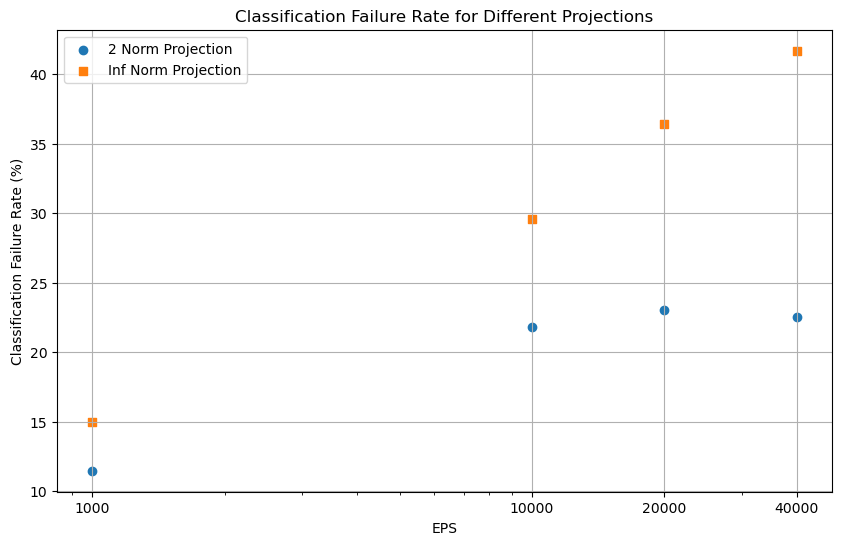

In [363]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/Users/yuxing/traffic-sign-detection/Parameters_filename.csv', sep=';')

# 'Projection' column contains NaN for 'No Projection', 'Inf' for infinity norm, and '2' for 2 norm
# Replace NaN with a string identifier for no projection
df['Projection'] = df['Projection'].fillna('None')

print(df)

# Filter rows where 'epsilon (for projection)' is 1000 or NaN (None in the context of the DataFrame)
df = df[(df['epsilon (for projection)'] == '1000') | (df['epsilon (for projection)'].isnull())]

# After fil

print(df)

# Grouping the dataframe by 'EPS' and 'Projection' to get the mean classification failure rate for each group
df_grouped = df.groupby(['EPS', 'Projection'])['Classification failure rate'].mean().reset_index()

# Plotting the classification failure rate for different EPS values for each projection type
projections = df_grouped['Projection'].unique()  # Get the unique projection types
markers = ['o', 's', '^']  # Different markers for each projection type

plt.figure(figsize=(10, 6))

# Loop through each projection type and plot it
for projection, marker in zip(projections, markers):
    subset = df_grouped[df_grouped['Projection'] == projection]
    plt.scatter(subset['EPS'], subset['Classification failure rate'], label=f'{projection} Norm Projection', marker=marker)

# Set the x-axis to a logarithmic scale
plt.xscale('log')

# Define the ticks you want to use on the x-axis
desired_ticks = [1000, 10000, 20000, 40000]

# Set the ticks on the x-axis to include your desired ticks
plt.gca().set_xticks(desired_ticks)

# Finalizing the plot
plt.title('Classification Failure Rate for Different Projections')
plt.xlabel('EPS')
plt.xticks(desired_ticks, desired_ticks)
plt.ylabel('Classification Failure Rate (%)')
plt.legend()
plt.grid(True)
plt.show()



In [364]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/Users/yuxing/traffic-sign-detection/Parameters_filename.csv', sep=';')

# Replace NaN with a string identifier for no projection
df['Projection'] = df['Projection'].fillna('None')

# Filter rows where 'epsilon (for projection)' is 1000 or None
df_filtered = df[df['epsilon (for projection)'] == 1000 or 'None']

# Grouping the dataframe by 'EPS' and 'Projection' to get the mean classification failure rate for each group
df_grouped = df_filtered.groupby(['EPS', 'Projection'])['Classification failure rate'].mean().reset_index()

# Plotting the classification failure rate for different EPS values for each projection type
projections = df_grouped['Projection'].unique()  # Get the unique projection types
markers = ['o', 's', '^']  # Different markers for each projection type

plt.figure(figsize=(10, 6))

# Loop through each projection type and plot it
for projection, marker in zip(projections, markers):
    subset = df_grouped[df_grouped['Projection'] == projection]
    plt.scatter(subset['EPS'], subset['Classification failure rate'], label=f'{projection} Norm Projection', marker=marker)

# Set the x-axis to a logarithmic scale
plt.xscale('log')

# Define the ticks you want to use on the x-axis
desired_ticks = [1000, 10000, 20000, 40000]

# Set the ticks on the x-axis to include your desired ticks
plt.gca().set_xticks(desired_ticks)
plt.gca().set_xticklabels(desired_ticks)

# Finalizing the plot
plt.title('Classification Failure Rate for Different Projections with Epsilon for Projection = 1000')
plt.xlabel('EPS')
plt.ylabel('Classification Failure Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Different Models

# l_inf Normalization